In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dca_df=pd.read_excel('DCA Test.xlsx')

In [3]:
dca_df.Date = pd.to_datetime(dca_df.Date)
dca_df.set_index('Date', inplace=True)

# Step 1---- Plotting the Production rate against time(in days)

In [4]:
dca_df.head()

,Rate (SCF/d)
Date,
2004-04-01,2706039.0
2004-05-01,2492086.2
2004-06-02,1816846.1
2004-07-02,1920207.4
2004-07-04,1683521.4


Can't analyse directly with date. There will be a need to generate a new column for the number of days which will be used for analysis.

In [5]:
# creating a column for days

dca_df['days'] = ((dca_df.index-dca_df.index.min())/pd.Timedelta(days=1)).astype(int)

In [6]:
dca_df.head()

,Rate (SCF/d),days
Date,,
2004-04-01,2706039.0,0
2004-05-01,2492086.2,30
2004-06-02,1816846.1,62
2004-07-02,1920207.4,92
2004-07-04,1683521.4,94


Now we can plot the production rate vs days

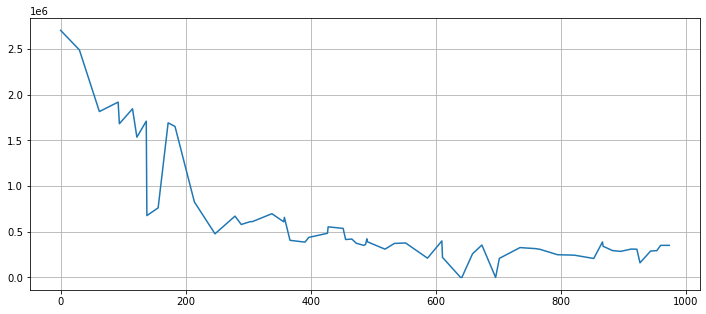

In [7]:
plt.figure(figsize=(12,5))

plt.plot(dca_df['days'], dca_df['Rate (SCF/d)'])
plt.grid();

The data is quite noisy here. We would need to create a curve that best fits the data points before further analysis (model optimization). 
Generally, the data shows a hyperbolic decline behaviour.

In [8]:
from scipy.optimize import curve_fit

In [9]:
# defining the hyperbolic model
def q_hyper(t,qi,D,b):
    
    qfit = qi/(np.abs(1+(b * D * t))**(1/b))
    
    return qfit

# defining a function that optimizes the parameters based on the hyperbolic model using curve_fit function
def hyperfit(q,t):
    
    #normalizing flow rate (q) and time (t) for a better convergence
    q_n = q/max(q)
    t_n = t/max(t)
    
    #optimizing parameters using curve_fit function
    params = curve_fit(q_hyper, t_n, q_n)
    [qi_n,D_n,b_n]=params[0] #these parameters are for normalized values of q and t
    
    #un-normalizing parameters for the actual values of q and t
    qi_fit = qi_n*max(q)
    D_fit = D_n/max(t)
    b_fit = b_n/max(t)
    
    #using the parameters to generate data for curve
    q_hyper_fit = q_hyper(t, qi_fit, D_fit, b_fit)
    
    return q_hyper_fit,params
    


In [10]:
q=dca_df['Rate (SCF/d)']
t=dca_df['days']

# flowrate array based on optimised parameters
q_fit,params=hyperfit(q,t)

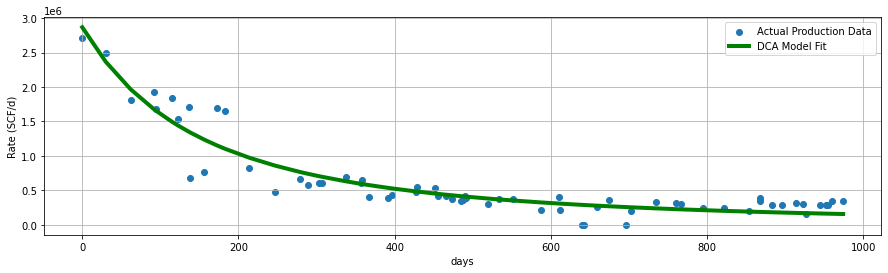

In [11]:
# plotting fitted model over the actual production data

plt.figure(figsize=(15,4))
plt.scatter(t,q,label='Actual Production Data')
plt.plot(t,q_fit,color='green',lw=4,label='DCA Model Fit')

plt.ylabel(dca_df.columns[0])
plt.xlabel('days')

plt.grid()
plt.legend();
     

# Step 2 ---- Determining the Cumulative production

The Cumulative production is the area under the curve. This can be done by using Numerical integration (trapezoidal rule used)

In [12]:
from scipy.integrate import trapz

In [47]:
cummulative_production= trapz(q_fit,t)

print(f'The cumulative production is {round(cummulative_production/10**6,2)} MMSCF')

The cumulative production is 656.8 MMSCF


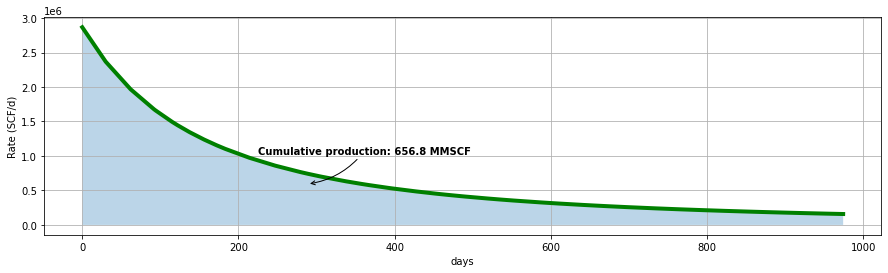

In [14]:
plt.figure(figsize=(15,4))

plt.plot(t,q_fit,color='green',lw=4)

plt.fill_between(t,q_fit, 0, alpha=0.3)

plt.annotate(f'Cumulative production: {round(cummulative_production/10**6,2)} MMSCF',
            xy=(t[15], q_fit[20]), xycoords = 'data', 
            xytext = (-50, 30), textcoords = 'offset points',
             fontweight='bold',
             arrowprops = dict(arrowstyle ="->",
                             connectionstyle = "arc3, rad =-0.2"))

plt.ylabel(dca_df.columns[0])
plt.xlabel('days')

plt.grid();
     

# Step 3 ---- Using model to predict future production and flow rate

In [36]:
# defining a function that accepts a day, then provide predictions 
# on the cumulative production and flow rate for that day

def predict(t_f):
    
    t_pred = np.append(dca_df['days'],np.arange(dca_df['days'][-1],t_f+1,5))
    
    [qi_n,D_n,b_n]=params[0]
    
    qi_fit = qi_n*max(q)
    D_fit = D_n/max(t)
    
    q_pred = q_hyper(t_pred,qi_fit,D_fit,b_n)
    
    flowrate= q_pred[-1]
    
    return t_pred,q_pred,flowrate

Let's say we would like to find the cumulative production from the gas reservoir after 1200 days (note that the original data stops at 974 days)

In [37]:
t_1200, q_1200, rate_1200 = predict(1200)

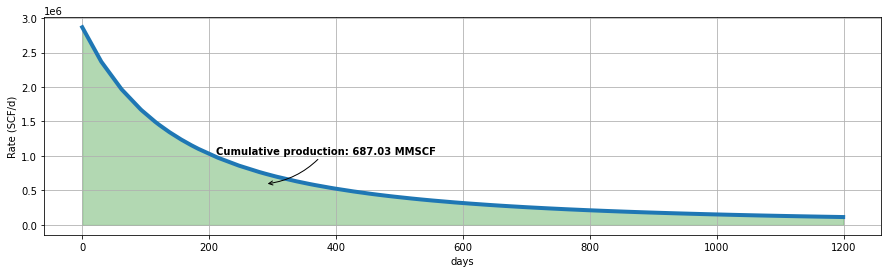

In [42]:
plt.figure(figsize=(15,4))

plt.plot(t_1200,q_1200,lw=4)
plt.fill_between(t_1200,q_1200, 0,color='green', alpha=0.3)

plt.annotate(f'Cumulative production: {round(trapz(q_1200,t_1200)/10**6,2)} MMSCF',
            xy=(t[15], q_fit[20]), xycoords = 'data', 
            xytext = (-50, 30), textcoords = 'offset points',
             fontweight='bold',
             arrowprops = dict(arrowstyle ="->",
                             connectionstyle = "arc3, rad =-0.2"))

plt.ylabel(dca_df.columns[0])
plt.xlabel('days')

plt.grid();

In [46]:
print(f'The flow rate at 1200 days is {round(rate_1200,1)} SCF/d')

The flow rate at 1200 days is 114158.6 SCF/d


We could go further to find the remaining gas reserves if the OGIP is known. For an OGIP of 800 MMSCF:

In [52]:
OGIP = 800 #MMSCF
G_cumm = round(trapz(q_1200,t_1200)/10**6,2)
G_rem = OGIP - G_cumm
print(f'The remaining gas reserve is {round(G_rem,2)} MMSCF')

The remaining gas reserve is 112.97 MMSCF
